In [1]:
from google.colab import drive
drive.mount("drive", force_remount=True)

Mounted at drive


# **1. Đọc dữ liệu**
Import các thư viện cần thiết.

In [2]:
# Text CNN 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, Bidirectional, GRU, Reshape, Conv2D, MaxPool2D, Concatenate, Flatten, Dropout
from keras.layers import Embedding
from keras.preprocessing import text, sequence
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from keras.models import Model
from keras import backend as K
from keras.utils import to_categorical
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

# from pyvi.ViTokenizer import ViTokenizer
# from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
# from unidecode import unidecode

# **2. Text CNN**

In [3]:
# Text CNN 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, Bidirectional, GRU, Reshape, Conv2D, MaxPool2D, Concatenate, Flatten, Dropout
from keras.layers import Embedding
from keras.preprocessing import text, sequence
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from keras.models import Model
from keras import backend as K
from keras.utils import to_categorical
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

In [21]:
# configuration 
EMBEDDING_FILE = '/content/drive/MyDrive/DS202_L11/Embedding/word2vec_vi_syllables_300dims.txt'

max_features = 20987
maxlen = 16

embed_size = 300
batch_size = 1024
epochs = 3

# read data
train = pd.read_csv('/content/drive/MyDrive/DS202_L11/Dataset/0_New_dataset/clean_train.csv')
test = pd.read_csv('/content/drive/MyDrive/DS202_L11/Dataset/0_New_dataset/clean_test.csv')

X_train = train['title']
X_test = test['title']
y_train = train['label']
y_test = test['label']

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11111, random_state=368, stratify=y_train)

In [23]:
# --------------TRICH XUAT DAC TRUNG -------------------------
tokenizer = text.Tokenizer(num_words=None, lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
#tokenizer = text.Tokenizer(num_words=None, lower=True)
tokenizer.fit_on_texts(X_train.astype(str))

In [24]:
# --------------END TRICH XUAT DAC TRUNG -------------------------
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embed_size))

max_features = num_words

for word, i in word_index.items():
    if i >= max_features:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [25]:
# ------------------- XAY DUNG MO HINH MANG NEURAL -----------------------
filter_sizes = [1,2,3,5]
num_filters = 64

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = SpatialDropout1D(0.4)(x)
x = Reshape((maxlen, embed_size, 1))(x)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embed_size), kernel_initializer='normal',
                activation='elu')(x)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embed_size), kernel_initializer='normal',
                activation='elu')(x)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embed_size), kernel_initializer='normal',
                activation='elu')(x)
conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], embed_size), kernel_initializer='normal',
                activation='elu')(x)

maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1))(conv_0)
maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1))(conv_1)
maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1))(conv_2)
maxpool_3 = MaxPool2D(pool_size=(maxlen - filter_sizes[3] + 1, 1))(conv_3)

z = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])
z = Flatten()(z)
z = Dropout(0.1)(z)


outp = Dense(13, activation="softmax")(z)

model = Model(inputs=inp, outputs=outp)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Epoch 1/3
204/204 [==============================] - 142s 691ms/step - loss: 1.7789 - accuracy: 0.4893 - val_loss: 0.7272 - val_accuracy: 0.7765
Epoch 2/3
204/204 [==============================] - 140s 685ms/step - loss: 0.6389 - accuracy: 0.8032 - val_loss: 0.6570 - val_accuracy: 0.7939
Epoch 3/3
26/26 [==============================] - 3s 109ms/step
Accuracy:  0.8007307692307692
F1-score:  0.800268100728634


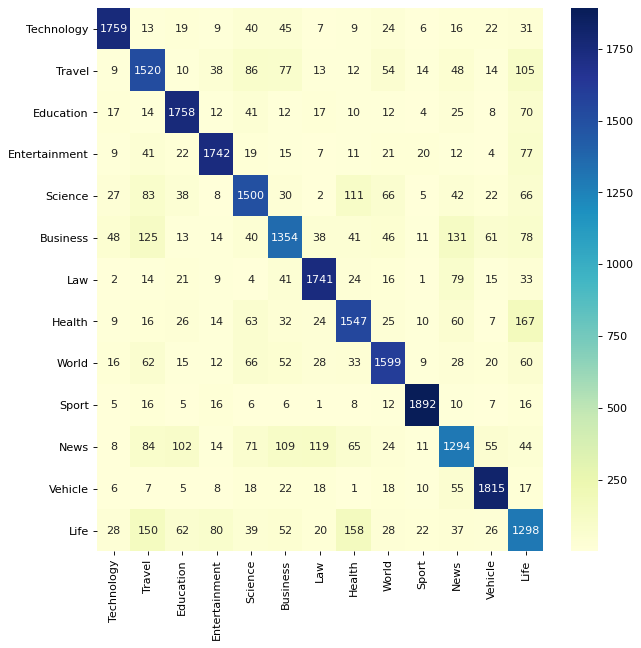

In [26]:
# ------------------- END XAY DUNG MO HINH MANG NEURAL -----------------------
X_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)

X_val = tokenizer.texts_to_sequences(X_val)
X_val = sequence.pad_sequences(X_val, maxlen=maxlen)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

y_train = to_categorical(y_train, num_classes=13)
y_val = to_categorical(y_val, num_classes=13)
y_test = y_test

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val))
prediction = model.predict(X_test, batch_size=batch_size, verbose=1)
y_test_pred = prediction.argmax(axis=-1)
acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='macro')
confuse = confusion_matrix(y_test, y_test_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

print("Accuracy: ", acc)
print("F1-score: ", f1)

plt.figure(figsize=(9,9), dpi=80)
sns.heatmap(confuse, annot=True, fmt="d", xticklabels=['Technology', 'Travel', 'Education', 'Entertainment', 'Science', 'Business', 'Law', 'Health', 'World', 'Sport', 'News', 'Vehicle', 'Life'], yticklabels=['Technology', 'Travel', 'Education', 'Entertainment', 'Science', 'Business', 'Law', 'Health', 'World', 'Sport', 'News', 'Vehicle', 'Life'], cmap='YlGnBu')